# Using Vector Autoregression (VAR) Method to Forecast with Scraped Data from The Weather Channel

We will first scrape some weather data off The Weather Channel website. I saved the required webpage as a .html file for future reference. After that, we will modify the dataset a bit and split it. We will use the VAR method to predict data. We will then evaluate the model by calculating the RMSE of each feature. P.S. Only a tiny bit of data could be scraped from the website. We will treat this project more like an experiment. This is a demonstration of an approach that can also be implemented onto larger datasets.

### Importing the libraries & packages

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

### Loading the Google Chrome Web Driver & importing a local HTML file

In [2]:
driver = webdriver.Chrome('chromedriver.exe') # This can also be downloaded from https://chromedriver.chromium.org/downloads
driver.get('file:///C:/Users/daved/Desktop/ML/Projects/Scrape/Forecast.html') # This can be replace with the web URL as well
content = driver.page_source
soup = BeautifulSoup(content)
table = soup.find_all('table', {'class':'twc-table'})

### Scraping the Data

In [3]:
l = []
for items in table:
 for i in range(len(items.find_all('tr'))-1):
  d = {}  
  d['Date_Time'] = items.find_all('span', {'class':'dsx-date'})[i].text
  d['Temperature'] = items.find_all('td', {'class':'temp'})[i].text
  d['Feels'] = items.find_all('td', {'class':'feels'})[i].text
  d['Precipitation'] = items.find_all('td', {'class':'precip'})[i].text
  d['Humidity'] = items.find_all('td', {'class':'humidity'})[i].text
  d['Wind'] = items.find_all('td', {'class':'wind'})[i].text
  l.append(d)

### Creating the dataframe, performing some data modification/cleaning & exporting it as a .CSV dataset

In [4]:
df = pd.DataFrame(l)
df2 = df['Wind'].str.split(' ', n = 1, expand = True)
df2[1] = df2[1].str.replace(r'\D', '')
df['Wind Speed'] = df2[1]
df['Temperature'] = df['Temperature'].str.replace(r'\D', '')
df['Feels'] = df['Feels'].str.replace(r'\D', '')
df['Precipitation'] = df['Precipitation'].str.replace(r'\D', '')
df['Humidity'] = df['Humidity'].str.replace(r'\D', '')
df = df.drop(['Wind'], axis = 1)
df3 = df['Date_Time']
df3.iloc[0:9, ] = '12-11-2019 ' + df3.iloc[0:9, ].astype(str)
df3.iloc[9:33, ] = '13-11-2019 ' + df3.iloc[9:33, ].astype(str)
df3.iloc[33:48, ] = '14-11-2019 ' + df3.iloc[33:48, ].astype(str)
df.to_csv('Weather Data.csv')
df.head()

,Date_Time,Temperature,Feels,Precipitation,Humidity,Wind Speed
0,12-11-2019 15:45,28,30,0,62,7
1,12-11-2019 16:00,28,30,0,63,7
2,12-11-2019 17:00,26,28,0,68,5
3,12-11-2019 18:00,25,25,0,71,4
4,12-11-2019 19:00,25,25,0,74,3


### Date_Time column is an object and we need to change it to datetime index

In [5]:
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d-%m-%Y %H:%M')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time
data.dtypes

Temperature      object
Feels            object
Precipitation    object
Humidity         object
Wind Speed       object
dtype: object

### Visualizing the features

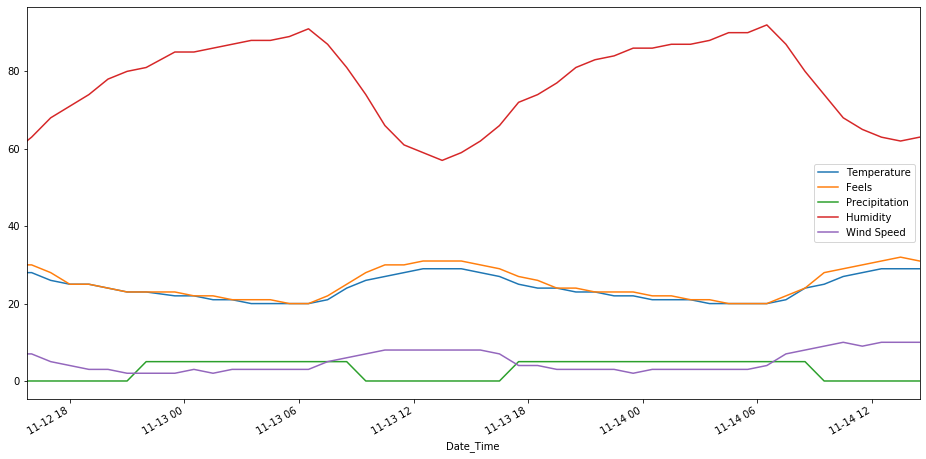

In [6]:
data.iloc[:, 0:5].astype(int).plot(figsize = (16, 8))
plt.legend()
plt.show()

### Augmented Dickey Fuller Test fto detect stationarity in the Time Series

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

##### Null Hypothesis (H0): 
If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

##### Alternate Hypothesis (H1): 
The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.


We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

#### p-value > 0.05: 
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

#### p-value <= 0.05: 
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [7]:
ADF_Temp = data['Temperature'].values.astype(int)
result = adfuller(ADF_Temp)
print('\033[1m Results for Temperature \033[0m')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

 Results for Temperature 
ADF Statistic: -3.144699
p-value: 0.023417
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


In [8]:
ADF_Wnsp = data['Wind Speed'].values.astype(int)
result = adfuller(ADF_Wnsp)
print('\033[1m Results for Wind Speed \033[0m')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

 Results for Wind Speed 
ADF Statistic: -1.968003
p-value: 0.300776
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


In [9]:
ADF_Feel = data['Feels'].values.astype(int)
result = adfuller(ADF_Feel)
print('\033[1m Results for Feels \033[0m')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

 Results for Feels 
ADF Statistic: -3.280583
p-value: 0.015769
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


In [10]:
ADF_Prcp = data['Precipitation'].values.astype(int)
result = adfuller(ADF_Prcp)
print('\033[1m Results for Precipitation \033[0m')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

 Results for Precipitation 
ADF Statistic: -2.071246
p-value: 0.256233
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


In [11]:
ADF_Hmdt = data['Humidity'].values.astype(int)
result = adfuller(ADF_Hmdt)
print('\033[1m Results for Humidity \033[0m')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

 Results for Humidity 
ADF Statistic: -3.585099
p-value: 0.006052
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


### Creating the Training and Validation set

In [12]:
train = data[:int(0.8*(len(data)))]
valid = data[int(0.8*(len(data))):]

In [13]:
train.head()

,Temperature,Feels,Precipitation,Humidity,Wind Speed
Date_Time,,,,,
2019-11-12 15:45:00,28,30,0,62,7
2019-11-12 16:00:00,28,30,0,63,7
2019-11-12 17:00:00,26,28,0,68,5
2019-11-12 18:00:00,25,25,0,71,4
2019-11-12 19:00:00,25,25,0,74,3


In [14]:
valid.head()

,Temperature,Feels,Precipitation,Humidity,Wind Speed
Date_Time,,,,,
2019-11-14 05:30:00,20,20,5,90,3
2019-11-14 06:30:00,20,20,5,92,4
2019-11-14 07:30:00,21,22,5,87,7
2019-11-14 08:30:00,24,24,5,80,8
2019-11-14 09:30:00,25,28,0,74,9


### Fitting a VAR model on the Training Set

In [15]:
model = VAR(endog = train.astype(int))
model_fit = model.fit()
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

### Converting Predictions to a Dataframe

In [16]:
cols = data.columns
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,5):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]
pred.head()

,Temperature,Feels,Precipitation,Humidity,Wind Speed
0,20.4671,20.9925,4.83062,89.2487,3.33391
1,21.05,21.8224,4.59798,87.2351,3.79314
2,21.6519,22.5919,4.30741,85.0656,4.2177
3,22.2333,23.309,3.9861,82.9704,4.57772
4,22.7693,23.9519,3.66665,81.0354,4.86512


### Checking the RMSE(s)

In [17]:
print('RMSE value for Temperature = ', math.sqrt(mean_squared_error(valid.iloc[:, 0:1].values, pred.iloc[:, 0:1])))

RMSE value for Temperature =  3.379906774933022


In [18]:
print('RMSE value for Feels = ', math.sqrt(mean_squared_error(valid.iloc[:, 1:2].values, pred.iloc[:, 1:2])))

RMSE value for Feels =  4.137149751737962


In [19]:
print('RMSE value for Precipitation = ', math.sqrt(mean_squared_error(valid.iloc[:, 2:3].values, pred.iloc[:, 2:3])))

RMSE value for Precipitation =  2.4427869808949456


In [20]:
print('RMSE value for Humidity = ', math.sqrt(mean_squared_error(valid.iloc[:, 3:4].values, pred.iloc[:, 3:4])))

RMSE value for Humidity =  9.60090877267055


In [21]:
print('RMSE value for Wind Speed = ', math.sqrt(mean_squared_error(valid.iloc[:, 4:5].values, pred.iloc[:, 4:5])))

RMSE value for Wind Speed =  3.7708689423768575


### Visually comparing Training and Validation Sets

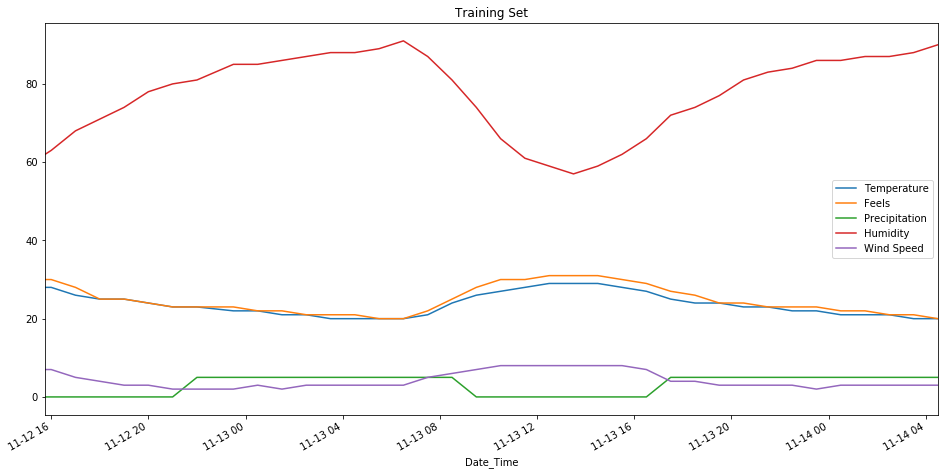

In [22]:
train.iloc[:,0:5].astype(int).plot(figsize = (16, 8))
plt.title('Training Set')
plt.legend(loc = 'best')
plt.show()

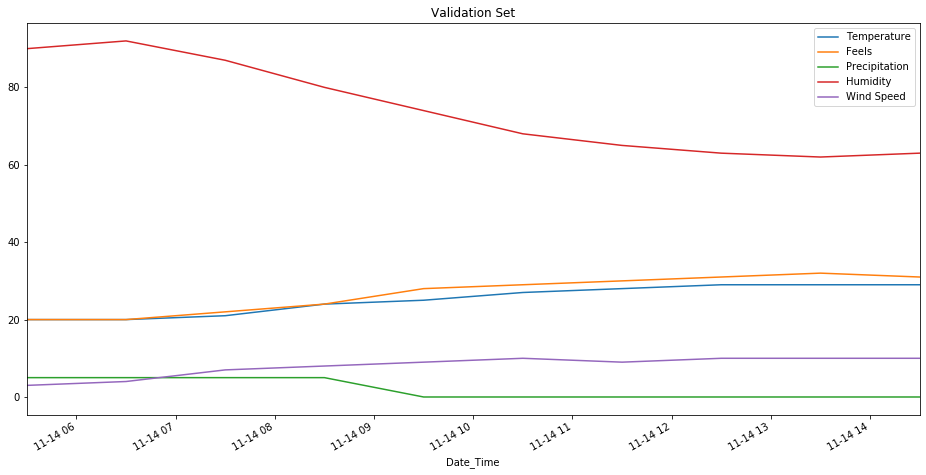

In [23]:
valid.iloc[:,0:5].astype(int).plot(figsize = (16, 8))
plt.title('Validation Set')
plt.legend(loc = 'best')
plt.show()